In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# original code from: https://github.com/soudey123/COVID-19-CHEST-X-RAY-IMAGE-CLASSIFICATION_UIUC

In [1]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
#import torch.optim as optim
#import torch.nn as nn
#import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
#from torchvision import models
#from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

num_workers = 0 # change this parameter based on your system configuration
batch_size = 32 # change this parameter based on your system configuration
seed = 24
random.seed(seed)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']

num_classes = len(categories)
splits = ['train', 'val', 'test']

data_path =  '/content/drive/MyDrive/DLH-COVID/data'
model_path = '/content/drive/MyDrive/DLH-COVID/model'

In [2]:
# Split original test folder randomly and equally between test and validation (new) folders
if not os.path.isdir(os.path.join(data_path, 'val')):
    os.mkdir(os.path.join(data_path, 'val'))
    for subdir in categories:   
        for root, dirs, files in os.walk(os.path.join(data_path, 'test/'+subdir)):
            size = len(files)
            migrate_index = random.sample(range(size), int(size/2))
            files_to_migrate = [files[i] for i in migrate_index]
            for file in files_to_migrate:
                file_path = os.path.join(data_path, 'test/' + subdir + '/' + file)
                new_dir = os.path.join(data_path, 'val/' + subdir)
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)
                if not os.path.exists(os.path.join(new_dir, file)):
                    a = shutil.move(file_path, new_dir)

In [3]:
def show_dataset_statistics(data_path):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))

    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
    
df_dataset = show_dataset_statistics(data_path)

          code train  val test  total
COVID19      0   460   58   58    576
NORMAL       1  1266  158  159   1583
PNEUMONIA    2  3418  427  428   4273
TOTAL           5144  643  645   6432


In [4]:
def get_datasets(data_path, num_workers=0):
    transform_operations = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_operations)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_operations)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_operations)
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    #val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    #test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, val_data, test_data

train_data, val_data, test_data = get_datasets(data_path)
concat_dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

print(f"Length of all data: {len(concat_dataset)}")

Length of all data: 6432


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


In [6]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns=metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

In [24]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model, train_loader, val_loader, epochs):
    t_start = time.time()
    best_val_epoch = 0

    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    
    train_size, val_size = len(train_loader), len(val_loader)

    for epoch in range(1, epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()

        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()

        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold, epochs):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

In [8]:
layer = [128, 128, 256, 256, 3]

class DLHNet(torch.nn.Module):
    def __init__(self):
        super(DLHNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, layer[0], 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(layer[0])
        self.pool1 = torch.nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = torch.nn.Conv2d(layer[0], layer[1], 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(layer[1])
        self.conv3 = torch.nn.Conv2d(layer[1], layer[2], 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(layer[2])
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = torch.nn.Linear(14 * 14 * layer[2], layer[3])
        self.linear2 = torch.nn.Linear(layer[3], layer[4])
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [9]:
np.random.seed(seed)
torch.manual_seed(seed)

net = DLHNet().to(device)

model_name = 'DLH_COVID'
n_epochs = 20
learning_rate = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Optional: use_scheduler = True will use dynamic values of learning_rate
use_scheduler = True  # Set True if using scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold = 0.001,
                                                 verbose=True, min_lr = 1e-5, threshold_mode = 'abs')


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

dlh_model, df_epochs = train_val_model(net, train_loader, val_loader, n_epochs)

Training model DLH_COVID with 5144 samples and max of 20 epochs, and validating with 643 samples



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1:	 train loss=0.40405 	 val loss=0.20187 	 time=1993.23s
Epoch 2:	 train loss=0.24413 	 val loss=0.15499 	 time=186.05s
Epoch 3:	 train loss=0.20190 	 val loss=0.13901 	 time=185.85s
Epoch 4:	 train loss=0.17341 	 val loss=0.13901 	 time=186.37s
Epoch 5:	 train loss=0.16668 	 val loss=0.13361 	 time=186.42s
Epoch 6:	 train loss=0.15217 	 val loss=0.13600 	 time=186.41s
Epoch 7:	 train loss=0.14356 	 val loss=0.11953 	 time=185.42s
Epoch 8:	 train loss=0.13206 	 val loss=0.13682 	 time=185.56s
Epoch 9:	 train loss=0.12240 	 val loss=0.11606 	 time=185.50s
Epoch 10:	 train loss=0.11517 	 val loss=0.11969 	 time=186.14s
Epoch 11:	 train loss=0.11085 	 val loss=0.11877 	 time=185.72s
Epoch 12:	 train loss=0.10617 	 val loss=0.11946 	 time=185.16s
Epoch 13:	 train loss=0.10382 	 val loss=0.11004 	 time=186.89s
Epoch 14:	 train loss=0.09441 	 val loss=0.11644 	 time=185.36s
Epoch 15:	 train loss=0.08994 	 val loss=0.10760 	 time=184.66s
Total time training and evaluating: 4594.81s


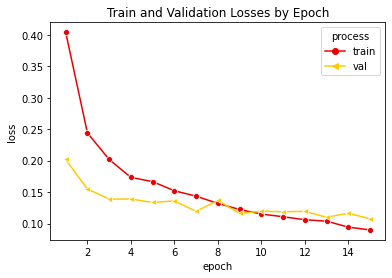

In [10]:
plot_train_val_losses(df_epochs)

In [11]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_results, conf_matrix_test = accuracy_model(dlh_model, test_loader)

Testing the model DLH_COVID with 645 samples 

              Accuracy  Precision   Recall  F1-score
Test Results  0.947287   0.950308  0.92831  0.938556


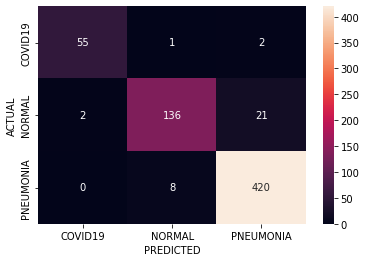

In [12]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

In [22]:
from sklearn.model_selection import KFold
def validate_model_kfold(dataset, model_name, k_folds):
    #model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(len(dataset))
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        
        model = DLHNet().to(device)
        model, df_vgg_epochs = train_val_model_kfold(model, train_kfold_loader, epochs = 10)
        predictions, actuals = calc_pred_actuals(model, test_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

In [25]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(concat_dataset, model_name = 'DLH_TEAM', k_folds = 5)

Validating the model DLH_TEAM with 5144 samples and 5-folds 

6432
Training model DLH_COVID with 5144 samples and max of 5 epochs
Epoch 1:	 train loss=1.12721 	 time=165.70s
Epoch 2:	 train loss=1.12861 	 time=165.47s
Epoch 3:	 train loss=1.13216 	 time=165.58s
Epoch 4:	 train loss=1.12712 	 time=165.50s
Epoch 5:	 train loss=1.13075 	 time=165.61s
Total time training and evaluating: 827.89s
Training model DLH_COVID with 5144 samples and max of 5 epochs
Epoch 1:	 train loss=1.05575 	 time=165.18s
Epoch 2:	 train loss=1.05375 	 time=164.87s
Epoch 3:	 train loss=1.05711 	 time=165.59s
Epoch 4:	 train loss=1.04995 	 time=165.47s
Epoch 5:	 train loss=1.06008 	 time=166.00s
Total time training and evaluating: 827.12s
Training model DLH_COVID with 5144 samples and max of 5 epochs
Epoch 1:	 train loss=1.29201 	 time=166.82s
Epoch 2:	 train loss=1.29557 	 time=165.73s
Epoch 3:	 train loss=1.29145 	 time=165.39s
Epoch 4:	 train loss=1.29740 	 time=165.52s
Epoch 5:	 train loss=1.29134 	 time=165.

In [27]:
print(validation_our_model_results)
print(conf_matrix_our_model_val)

         Accuracy  Precision    Recall  F1-score
FOLD 1   0.332556   0.294658  0.277184  0.264386
FOLD 2   0.484071   0.322263  0.329808  0.314285
FOLD 3   0.135303   0.342779  0.338396  0.131162
FOLD 4   0.479005   0.358315  0.368610  0.358382
FOLD 5   0.269051   0.383950  0.376138  0.257675
Average  0.339997   0.340393  0.338027  0.265178
PREDICTED    0    1    2
ACTUAL                  
0           49   41   15
1          132  151   22
2          342  388  146


# FEDERATED

In [29]:
from collections import OrderedDict

def update_client(federated_model, client):
    client.load_state_dict(federated_model.state_dict(), True)
    return client
    
def federated_average(federated_model, client_models):
    average_weights = OrderedDict()

    for client_model in client_models:
        for key, value in client_model.state_dict().items():
            if key in average_weights:
                average_weights[key] += (1./number_of_clients) * value.clone()
            else:
                average_weights[key] = (1./number_of_clients) * value.clone()
                
                
    federated_model.load_state_dict(average_weights, True)
    return federated_model
    

In [42]:
def federated_train_val_model(model, train_loader, val_loader, optimizer, criterion):
    # Beginning of training step
    
    model.train()
    train_loss, val_loss = 0.0, 0.0
    for i, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().cpu().numpy()

    # Beginning of evaluation step
    model.eval()
    for j, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        val_loss += loss.detach().cpu().numpy()

    return train_loss, val_loss

    

In [49]:
def run_federated_training(
    federated_model,
    client_models,
    client_training_loader,
    client_val_loader,
    number_of_clients
):
  np.random.seed(seed)
  torch.manual_seed(seed)

  model_name = 'FEDERATED_DLH_COVID'
  n_epochs = 20
  learning_rate = 1e-3
  latest_learning_rate = learning_rate

  criterion = torch.nn.CrossEntropyLoss()

  t_start = time.time()
  best_val_epoch = 0

  df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
  print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
  
  train_size, val_size = len(client_training_loader[0])*number_of_clients, len(client_val_loader[0])*number_of_clients

  # Optional: use_scheduler = True will use dynamic values of learning_rate
  use_scheduler = True  # Set True if using scheduler
  federated_scheduler = None

  for epoch in range(1, n_epochs+1):
    t0 = time.time()
    train_losses = []
    val_losses = []
    for client_idx in range (number_of_clients):
      print(f"+++ FEDERATED MODEL {client_idx}, EPOCH: {epoch} +++++++++")

      client_model = client_models[client_idx]
      client_model.to(device)
      client_model = update_client(federated_model, client_model)
      client_optimizer = torch.optim.SGD(client_model.parameters(), lr=latest_learning_rate)

      federated_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold = 0.001,
                                                  verbose=True, min_lr = 1e-5, threshold_mode = 'abs')

      train_loss, val_loss = federated_train_val_model(
          client_model,
          client_training_loader[client_idx],
          client_val_loader[client_idx],
          client_optimizer,
          criterion
      )

      train_losses += [train_loss]
      val_losses += [val_loss]

      if device.type == "cuda": 
          torch.cuda.empty_cache()
      
      client_model.to("cpu")

    federated_model = federated_average(federated_model, client_models)
    
    epoch_train_loss = sum(train_losses)/len(train_losses)
    epoch_val_loss = sum(val_losses)/len(val_losses)

    print(f"Epoch {epoch}:\t average train loss={epoch_train_loss/train_size:.5f} \t average val loss={epoch_val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
    df.loc[len(df)] = [model_name, epoch, epoch_train_loss/train_size, epoch_val_loss/val_size]
    if epoch >= best_val_epoch + 15:
        break
    if use_scheduler and federated_scheduler is not None:
      federated_scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
      # ReduceLROnPlateau is the only scheduler which has no `get_last_lr` method, get it with internal list
      # latest_learning_rate = federated_scheduler.get_last_lr()
      latest_learning_rate = federated_scheduler._last_lr[0]

  #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
  print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
  return federated_model, df



In [50]:
number_of_clients = 4
federated_model = DLHNet().to(device)

client_models = [DLHNet() for _ in range(number_of_clients)]

train_size_per_client = len(train_data) // number_of_clients # train data is split to clients
train_indices_clients = np.random.permutation(np.arange(train_size_per_client * number_of_clients))

val_size_per_client = len(val_data) // number_of_clients # train data is split to clients
val_indices_clients = np.random.permutation(np.arange(val_size_per_client * number_of_clients))

client_training_loader = []
client_val_loader = []
for idx in range(number_of_clients):
    client_training_subset = torch.utils.data.Subset(train_data, train_indices_clients[idx*train_size_per_client:(idx+1)*train_size_per_client])
    client_training_loader += [torch.utils.data.DataLoader(client_training_subset, batch_size=batch_size, shuffle=True, num_workers=0)]

    client_val_subset = torch.utils.data.Subset(val_data, val_indices_clients[idx*val_size_per_client:(idx+1)*val_size_per_client])
    client_val_loader += [torch.utils.data.DataLoader(client_val_subset, batch_size=batch_size, shuffle=True, num_workers=0)]


In [51]:
trained_federated_model, federated_df_epochs = run_federated_training(federated_model, client_models, client_training_loader, client_val_loader, number_of_clients)

Training model FEDERATED_DLH_COVID with 5144 samples and max of 20 epochs, and validating with 643 samples

+++ FEDERATED MODEL 0, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 1, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 1 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 1 +++++++++
Epoch 1:	 average train loss=0.15267 	 average val loss=0.16586 	 time=187.34s
+++ FEDERATED MODEL 0, EPOCH: 2 +++++++++
+++ FEDERATED MODEL 1, EPOCH: 2 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 2 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 2 +++++++++
Epoch 2:	 average train loss=0.09975 	 average val loss=0.09826 	 time=186.25s
+++ FEDERATED MODEL 0, EPOCH: 3 +++++++++
+++ FEDERATED MODEL 1, EPOCH: 3 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 3 +++++++++
+++ FEDERATED MODEL 3, EPOCH: 3 +++++++++
Epoch 3:	 average train loss=0.08325 	 average val loss=0.08057 	 time=186.61s
+++ FEDERATED MODEL 0, EPOCH: 4 +++++++++
+++ FEDERATED MODEL 1, EPOCH: 4 +++++++++
+++ FEDERATED MODEL 2, EPOCH: 4 +++++++++
+++ FEDERATED MODEL 3, EP

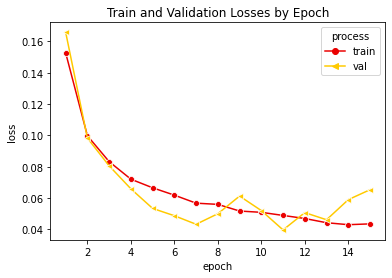

In [52]:
plot_train_val_losses(federated_df_epochs)

In [53]:
federated_test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)
federated_test_results, federated_conf_matrix_test = accuracy_model(trained_federated_model, federated_test_loader)

Testing the model DLH_COVID with 645 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.950388   0.952337  0.934123  0.942962


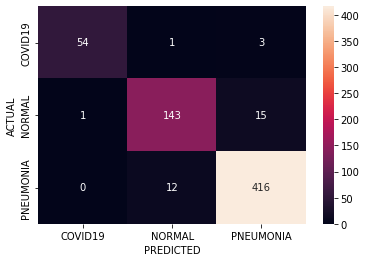

In [54]:
_ = sns.heatmap(federated_conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)